## 使用T5预训练模型提取特征向量
参考：https://www.kaggle.com/code/sergeifironov/t5embeds-calculation-only-few-samples  
`!pip install obonet`  
`!pip install pyvis`

In [1]:
import os
import json
from typing import Dict
from collections import Counter
import pandas as pd
import random
# import obonet
import pandas as pd
import numpy as np
from Bio import SeqIO

from transformers import T5Tokenizer, T5EncoderModel
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False) #.to(device)
# Load the model
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc").to(device)

# only GPUs support half-precision currently; if you want to run on CPU use full-precision (not recommended, much slower)
model.full() if device=='cpu' else model.half()

/home/bli/.conda/envs/ag/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


T5EncoderModel(
  (shared): Embedding(128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, bias=False)
              (dropout): Dropo

In [2]:
import re
def get_embeddings(seq):
    sequence_examples = [" ".join(list(re.sub(r"[UZOB]", "X", seq)))]

    ids = tokenizer.batch_encode_plus(sequence_examples, add_special_tokens=True, padding="longest")

    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    # generate embeddings
    with torch.no_grad():
        embedding_repr = model(input_ids=input_ids,
                               attention_mask=attention_mask)

    # extract residue embeddings for the first ([0,:]) sequence in the batch and remove padded & special tokens ([0,:7]) 
    emb_0 = embedding_repr.last_hidden_state[0]
    emb_0_per_protein = emb_0.mean(dim=0)
    
    return emb_0_per_protein

In [3]:
DATA_PATH = "../dataset/dataset2.0/" # Path to data
EMBED_PATH =DATA_PATH+'/T5_embed/'

EMB_LAYER = 33
import tqdm
def extract_embed(data_file):    
    
    input_data  =DATA_PATH+data_file
    output_dir = EMBED_PATH
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    data_df = pd.read_csv(input_data)
    num_sequences  =len(data_df)
    ids = []
    embeds = np.zeros((num_sequences, 1024))
    i = 0
    for idnex,row in tqdm.tqdm(data_df.iterrows()):
        ids.append(row['id'])
        embeds[i] = get_embeddings(str(row['seq'])).detach().cpu().numpy()
        i += 1
    
    np.save(output_dir+'{}_embeds.npy'.format(data_file.split('.')[0]), embeds)
    np.save(output_dir+'{}_ids.npy'.format(data_file.split('.')[0]), np.array(ids))
    print('Extract T5 embeddings for {}, save in {}'.format(input_data,output_dir))

In [4]:
for file in os.listdir(DATA_PATH):
    if file.endswith('.csv'):
        print(file)
        extract_embed(file)

test_data1_2023-6-9_15_31.csv


226it [00:10, 20.85it/s]


Extract T5 embeddings for ../dataset/dataset2.0/test_data1_2023-6-9_15_31.csv, save in ../dataset/dataset2.0//T5_embed/
test_data2_2023-6-9_15_31.csv


274it [00:09, 28.44it/s]


Extract T5 embeddings for ../dataset/dataset2.0/test_data2_2023-6-9_15_31.csv, save in ../dataset/dataset2.0//T5_embed/
positive_train_422.csv


422it [00:21, 19.55it/s]


Extract T5 embeddings for ../dataset/dataset2.0/positive_train_422.csv, save in ../dataset/dataset2.0//T5_embed/
negative_train_3307.csv


3307it [02:04, 26.61it/s]

Extract T5 embeddings for ../dataset/dataset2.0/negative_train_3307.csv, save in ../dataset/dataset2.0//T5_embed/


In [5]:
# DATA_PATH = "../dataset/dataset1.0/" # Path to data
# EMBED_PATH =DATA_PATH+'T5_embed/'
# EMB_LAYER = 33

import os
import torch
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
def load_T5_embed(csv_file):
    Embed_PATH = EMBED_PATH+csv_file.split('.')[0]+'_embeds.npy'
    data_df =  pd.read_csv(DATA_PATH+csv_file)
    ys = data_df['label']
    Xs = np.load(Embed_PATH)
    print('load{} T5 embedding from {}'.format(csv_file,Embed_PATH))
    print(len(ys))
    print(Xs.shape)
    return Xs,ys
Xs = []
ys = []
for file in os.listdir(DATA_PATH):
    if file.endswith('.csv'):
        if file.endswith('llpsdb_d.csv'):continue
        x,y = load_T5_embed(file)
        Xs.append(x)
        ys.append(y)
Xs = np.vstack((*Xs,))
ys = [y for sub in ys for y in sub]
print(len(ys))
print(Xs.shape)
num_pca_components = 100
pca = PCA(num_pca_components)
Xs_pca = pca.fit_transform(Xs)

loadtest_data1_2023-6-9_15_31.csv T5 embedding from ../dataset/dataset2.0//T5_embed/test_data1_2023-6-9_15_31_embeds.npy
226
(226, 1024)
loadtest_data2_2023-6-9_15_31.csv T5 embedding from ../dataset/dataset2.0//T5_embed/test_data2_2023-6-9_15_31_embeds.npy
274
(274, 1024)
loadpositive_train_422.csv T5 embedding from ../dataset/dataset2.0//T5_embed/positive_train_422_embeds.npy
422
(422, 1024)
loadnegative_train_3307.csv T5 embedding from ../dataset/dataset2.0//T5_embed/negative_train_3307_embeds.npy
3307
(3307, 1024)
4229
(4229, 1024)


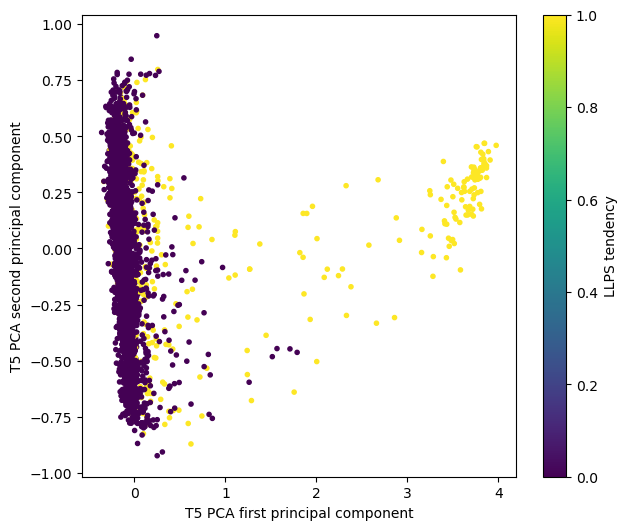

In [6]:
import matplotlib.pyplot as plt
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_pca[:,0], Xs_pca[:,1], c=ys, marker='.')
ax.set_xlabel('T5 PCA first principal component')
ax.set_ylabel('T5 PCA second principal component')
plt.colorbar(sc, label='LLPS tendency')